1- Description of the data:
Let us know how you use the data. How many rows? How many columns? How many nulls are in each? Have you removed any part? How do you work on the nulls? Do you do any transformation? Did you see troubles with the size of the data? 

In [2]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[*]').appName('null_cnt').getOrCreate()
sc = spark.sparkContext

In [3]:
df1 = spark.read.csv('anxiety_merged_With_Covid_Index.csv', sep=",",header=True, inferSchema=True)

In [4]:
# 发现年龄有负数
df1.summary().toPandas()

,summary,ISR,CASE,AGE,GNDR_COD,WT,PT,OUTC_COD,DRUGNAME,INDI_PT,YEAR,COVID
0,count,1910209,1910209,1587621,1910209,1184492,1908302,1680054,1910209,1910209,1910209,1910209
1,mean,2.0336054932512674E8,1.2029393191069145E7,49.50857323291282,None,74.87460973834304,None,None,1.2102004E7,None,2015.0673177647054,None
2,stddev,3.878669971080241E8,5039070.996941432,18.129432003719835,None,27.423436054070503,None,None,0.0,None,5.320585643961081,None
3,min,4262067,3159819.0,-5.0,F,0.0,5-HYDROXYINDOLACETIC ACID IN URINE INCREASED,CA,ESCITALOPRAM,anxiety,2004,N
4,25%,7424881,7555702.0,39.0,None,60.771,None,None,1.2102004E7,None,2011,None
5,50%,118130011,1.1299346E7,51.0,None,73.47,None,None,1.2102004E7,None,2016,None
6,75%,174023611,1.6168897E7,62.0,None,90.6,None,None,1.2102004E7,None,2020,None
7,max,2237453814,2.3015152E7,106.0,M,1109.8,pH urine increased,RI,zopiclone,anxiety,2023,Y


In [5]:
# 发现除了OT和HO，CA（先天异常）占比很大，认为可以直接把-1~-5转化为1~5，猜测可能是数据集读取问题
from pyspark.sql.functions import *
df2 = df1.filter("AGE < 0").select("*")
df2.groupBy('OUTC_COD').agg(count("ISR")).orderBy(count("ISR"), ascending = False).show()

+--------+----------+
|OUTC_COD|count(ISR)|
+--------+----------+
|      OT|       790|
|      CA|       755|
|      HO|       717|
|      DE|       110|
|      LT|        91|
|    null|        10|
+--------+----------+



In [6]:
# 用ABS解决这个问题
from pyspark.sql.functions import abs as spark_abs
df1 = df1.withColumn('AGE', spark_abs(df1['AGE']))

In [7]:
#dataframe的基本情况，包括行和列
print('The number of rows: ',df1.count())
print('The number of columns: ',len(df1.columns))

The number of rows:  1910209
The number of columns:  11


In [8]:
from pyspark.sql.functions import *
#利用pyspark查看各列的空值情况
cnt_na = df1.select([count(when(col(c).contains('None') | \
                     col(c).contains('NULL') | \
                     (col(c)=='') | \
                     col(c).isNull() |\
                     isnan(c), c
                     )).alias(c)
          for c in df1.columns])
cnt_na.show()

+---+----+------+--------+------+----+--------+--------+-------+----+-----+
|ISR|CASE|   AGE|GNDR_COD|    WT|  PT|OUTC_COD|DRUGNAME|INDI_PT|YEAR|COVID|
+---+----+------+--------+------+----+--------+--------+-------+----+-----+
|  0|   0|322588|       0|725717|1907|  230155|       0|      0|   0|    0|
+---+----+------+--------+------+----+--------+--------+-------+----+-----+



In [9]:
#查看性别类型
df1.select('GNDR_COD').distinct().show()

+--------+
|GNDR_COD|
+--------+
|       F|
|       M|
+--------+



In [10]:
#分别计算男性和女性的平均体重
from pyspark.sql.functions import *
mean_by_gender = df1.groupBy('GNDR_COD').agg(mean('WT').alias('mean_WT'))
mean_male = mean_by_gender.filter(mean_by_gender['GNDR_COD'] == 'M').select('mean_WT').collect()[0][0]
mean_female = mean_by_gender.filter(mean_by_gender['GNDR_COD'] == 'F').select('mean_WT').collect()[0][0]
#用平均体重替换男女体重为空值的cell
df2 = df1.withColumn(
    'WT', 
    when(df1['GNDR_COD'] == 'M', when(df1['WT'].isNull(), mean_male).otherwise(df1['WT']))
    .otherwise(when(df1['WT'].isNull(), mean_female).otherwise(df1['WT'])))
df2.show()

+-------+---------+----+--------+-----------------+--------------------+--------+--------+-------+----+-----+
|    ISR|     CASE| AGE|GNDR_COD|               WT|                  PT|OUTC_COD|DRUGNAME|INDI_PT|YEAR|COVID|
+-------+---------+----+--------+-----------------+--------------------+--------+--------+-------+----+-----+
|4262067|4053575.0|41.0|       F| 72.6419470689881|             AMNESIA|      OT| SEROXAT|anxiety|2004|    N|
|4262067|4053575.0|41.0|       F| 72.6419470689881|           DIZZINESS|      OT| SEROXAT|anxiety|2004|    N|
|4262067|4053575.0|41.0|       F| 72.6419470689881|     DRUG DEPENDENCE|      OT| SEROXAT|anxiety|2004|    N|
|4262067|4053575.0|41.0|       F| 72.6419470689881|DRUG WITHDRAWAL S...|      OT| SEROXAT|anxiety|2004|    N|
|4262067|4053575.0|41.0|       F| 72.6419470689881|    FEELING ABNORMAL|      OT| SEROXAT|anxiety|2004|    N|
|4262067|4053575.0|41.0|       F| 72.6419470689881|            HEADACHE|      OT| SEROXAT|anxiety|2004|    N|
|4262067|4

In [11]:
#查看当前空值情况
cnt_na2 = df2.select([count(when(col(c).contains('None') | \
                     col(c).contains('NULL') | \
                     (col(c)=='') | \
                     col(c).isNull() |\
                     isnan(c), c
                     )).alias(c)
          for c in df2.columns])
cnt_na2.show()

+---+----+------+--------+---+----+--------+--------+-------+----+-----+
|ISR|CASE|   AGE|GNDR_COD| WT|  PT|OUTC_COD|DRUGNAME|INDI_PT|YEAR|COVID|
+---+----+------+--------+---+----+--------+--------+-------+----+-----+
|  0|   0|322588|       0|  0|1907|  230155|       0|      0|   0|    0|
+---+----+------+--------+---+----+--------+--------+-------+----+-----+



In [12]:
#查看同时满足年龄和OUTC_COD为空值的情况
df_with_null_check = df2.withColumn("both_null", when(col("AGE").isNull() & col("OUTC_COD").isNull(), True).otherwise(False))
df_filtered = df_with_null_check.filter(col("both_null"))
df_filtered.count()

55114

In [13]:
#数量上可以接受，于是drop rows where age and outc_cod are both nulls
df3 = df2.withColumn("both_null", when(col("AGE").isNull() & col("OUTC_COD").isNull(), True).otherwise(False))
df4 = df3.where(df3['both_null'] != True)
df5 = df4.drop('both_null')
#查看当前空值情况
cnt_na5 = df5.select([count(when(col(c).contains('None') | \
                     col(c).contains('NULL') | \
                     (col(c)=='') | \
                     col(c).isNull() |\
                     isnan(c), c
                     )).alias(c)
          for c in df5.columns])
cnt_na5.show()

+---+----+------+--------+---+----+--------+--------+-------+----+-----+
|ISR|CASE|   AGE|GNDR_COD| WT|  PT|OUTC_COD|DRUGNAME|INDI_PT|YEAR|COVID|
+---+----+------+--------+---+----+--------+--------+-------+----+-----+
|  0|   0|267474|       0|  0|1827|  175041|       0|      0|   0|    0|
+---+----+------+--------+---+----+--------+--------+-------+----+-----+



In [14]:
#查看OUTC_COD类型
df5.select('OUTC_COD').distinct().show()

+--------+
|OUTC_COD|
+--------+
|      LT|
|    null|
|      RI|
|      CA|
|      HO|
|      DE|
|      DS|
|      OT|
+--------+



In [15]:
#依照OUTC_COD类型计算其对应的平均年龄
mean_by_age = df5.groupBy('OUTC_COD').agg(mean('AGE').alias('mean_age'))
mean_lt = mean_by_age.filter(mean_by_age['OUTC_COD'] == 'LT').select('mean_age').collect()[0][0]
mean_ri = mean_by_age.filter(mean_by_age['OUTC_COD'] == 'RI').select('mean_age').collect()[0][0]
mean_ca = mean_by_age.filter(mean_by_age['OUTC_COD'] == 'CA').select('mean_age').collect()[0][0]
mean_ho = mean_by_age.filter(mean_by_age['OUTC_COD'] == 'HO').select('mean_age').collect()[0][0]
mean_de = mean_by_age.filter(mean_by_age['OUTC_COD'] == 'DE').select('mean_age').collect()[0][0]
mean_ds = mean_by_age.filter(mean_by_age['OUTC_COD'] == 'DS').select('mean_age').collect()[0][0]
mean_ot = mean_by_age.filter(mean_by_age['OUTC_COD'] == 'OT').select('mean_age').collect()[0][0]
#用平均年龄替换OUTC_COD不同类型对应年龄为空值的cell
from pyspark.sql import functions as F
df6 = df5.withColumn('AGE',
    F.when(df5['OUTC_COD'] == 'LT', F.when(df5['AGE'].isNull(), mean_lt).otherwise(df5['AGE']))
     .when(df5['OUTC_COD'] == 'RI', F.when(df5['AGE'].isNull(), mean_ri).otherwise(df5['AGE']))
     .when(df5['OUTC_COD'] == 'CA', F.when(df5['AGE'].isNull(), mean_ca).otherwise(df5['AGE']))
     .when(df5['OUTC_COD'] == 'HO', F.when(df5['AGE'].isNull(), mean_ho).otherwise(df5['AGE']))
     .when(df5['OUTC_COD'] == 'DE', F.when(df5['AGE'].isNull(), mean_de).otherwise(df5['AGE']))
     .when(df5['OUTC_COD'] == 'DS', F.when(df5['AGE'].isNull(), mean_ds).otherwise(df5['AGE']))
     .when(df5['OUTC_COD'] == 'OT', F.when(df5['AGE'].isNull(), mean_ot).otherwise(df5['AGE']))
     .otherwise(df5['AGE']))
df6.show()

+-------+---------+----+--------+-----------------+--------------------+--------+--------+-------+----+-----+
|    ISR|     CASE| AGE|GNDR_COD|               WT|                  PT|OUTC_COD|DRUGNAME|INDI_PT|YEAR|COVID|
+-------+---------+----+--------+-----------------+--------------------+--------+--------+-------+----+-----+
|4262067|4053575.0|41.0|       F| 72.6419470689881|             AMNESIA|      OT| SEROXAT|anxiety|2004|    N|
|4262067|4053575.0|41.0|       F| 72.6419470689881|           DIZZINESS|      OT| SEROXAT|anxiety|2004|    N|
|4262067|4053575.0|41.0|       F| 72.6419470689881|     DRUG DEPENDENCE|      OT| SEROXAT|anxiety|2004|    N|
|4262067|4053575.0|41.0|       F| 72.6419470689881|DRUG WITHDRAWAL S...|      OT| SEROXAT|anxiety|2004|    N|
|4262067|4053575.0|41.0|       F| 72.6419470689881|    FEELING ABNORMAL|      OT| SEROXAT|anxiety|2004|    N|
|4262067|4053575.0|41.0|       F| 72.6419470689881|            HEADACHE|      OT| SEROXAT|anxiety|2004|    N|
|4262067|4

In [16]:
#查看当前空值情况
cnt_na6 = df6.select([count(when(col(c).contains('None') | \
                     col(c).contains('NULL') | \
                     (col(c)=='') | \
                     col(c).isNull() |\
                     isnan(c), c
                     )).alias(c)
          for c in df6.columns])
cnt_na6.show()

+---+----+---+--------+---+----+--------+--------+-------+----+-----+
|ISR|CASE|AGE|GNDR_COD| WT|  PT|OUTC_COD|DRUGNAME|INDI_PT|YEAR|COVID|
+---+----+---+--------+---+----+--------+--------+-------+----+-----+
|  0|   0|  0|       0|  0|1827|  175041|       0|      0|   0|    0|
+---+----+---+--------+---+----+--------+--------+-------+----+-----+



In [17]:
#由于PT空值和剩余OUTC_COD空值的关联性较弱，无法获取合适的填充值，故将这两列出现null的行全部剔除
df6 = df6.na.drop(subset=['PT'])
df6 = df6.na.drop(subset=['OUTC_COD'])

In [18]:
#查看当前空置情况，完成空值清理
cnt_na7 = df6.select([count(when(col(c).contains('None') | \
                     col(c).contains('NULL') | \
                     (col(c)=='') | \
                     col(c).isNull() |\
                     isnan(c), c
                     )).alias(c)
          for c in df6.columns])
cnt_na7.show()

+---+----+---+--------+---+---+--------+--------+-------+----+-----+
|ISR|CASE|AGE|GNDR_COD| WT| PT|OUTC_COD|DRUGNAME|INDI_PT|YEAR|COVID|
+---+----+---+--------+---+---+--------+--------+-------+----+-----+
|  0|   0|  0|       0|  0|  0|       0|       0|      0|   0|    0|
+---+----+---+--------+---+---+--------+--------+-------+----+-----+



3- Description of the disease?

In [19]:
#How many patients
df6.select(["CASE"]).distinct().count()

85639

In [20]:
# Is it serious?  （重症率, DE/HO/RI算重症）
serious_outc_count = df6.filter((df6["OUTC_COD"] == "DE") | (df6["OUTC_COD"] == "HO") 
                                | (df6["OUTC_COD"] == "RI")).select(["ISR"]).count()
outc_count = df6.select(["ISR"]).count()
serious_rate = serious_outc_count / outc_count
serious_rate

0.3803845938445443

In [21]:
# a)阳了以后有新的相关PT出现
df7 = df6.filter("YEAR >= 2020") #2020年疫情全面爆发
df8 = df7.toPandas()
PT_counts = df8.loc[df8.COVID == "Y"].groupby("PT")["ISR"].count()
list(PT_counts.index)

['COVID-19',
 'COVID-19 immunisation',
 'COVID-19 pneumonia',
 'Corona virus infection',
 'Post-acute COVID-19 syndrome',
 'Suspected COVID-19']

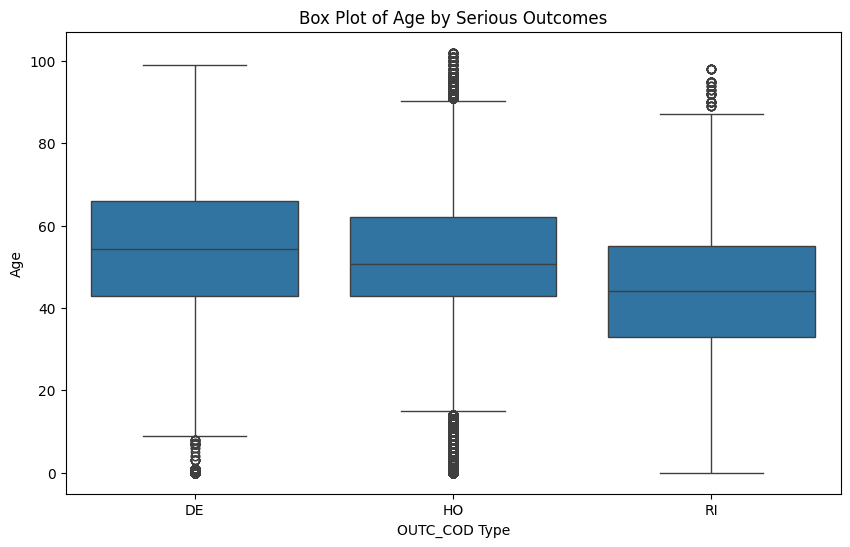

In [22]:
# b)重症患者的年龄分布情况
import matplotlib.pyplot as plt
import seaborn as sns
dfs = df6.filter(col("OUTC_COD").isin(['RI', 'HO', 'DE'])).toPandas()
plt.figure(figsize=(10, 6))
sns.boxplot(x='OUTC_COD', y='AGE', data=dfs)
plt.title('Box Plot of Age by Serious Outcomes')
plt.xlabel('OUTC_COD Type')
plt.ylabel('Age')
plt.show()

In [23]:
#c)无法通过K-means得到很好的分类
# 只看重症情况
df9 = df7.filter((df7["OUTC_COD"] == "DE") | (df7["OUTC_COD"] == "HO") | (df7["OUTC_COD"] == "RI")).select("*")
# str->index
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index")
            .fit(df9) for column in ['GNDR_COD', 'COVID', 'PT', 'DRUGNAME', 'OUTC_COD']]
pipeline = Pipeline(stages=indexers)
df10 = pipeline.fit(df9).transform(df9)
df10 = df10.drop('GNDR_COD', 'COVID', 'OUTC_COD', 'PT', 'DRUGNAME', 'INDI_PT')
# 把从第二列开始的列存入feature里面
feature = VectorAssembler(inputCols = df10.columns[2:9], outputCol = "features")
# 创建feature向量
feature_vector = feature.transform(df10)
# make the data into standards range
from pyspark.ml.feature import StandardScaler
scale = StandardScaler(inputCol = "features", outputCol = "standardized")
data_scale = scale.fit(feature_vector)
data_scale_output = data_scale.transform(feature_vector)
# k-means
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator(predictionCol = "prediction", featuresCol = "standardized",
                               metricName = "silhouette", distanceMeasure = "squaredEuclidean")
# metricName = "silhouette": way to find - what is the best number of clusters?
for i in range(2,10): #2-9
    KMeans_algo = KMeans(featuresCol = "standardized", k = i)
    KMeans_fit = KMeans_algo.fit(data_scale_output)
    output = KMeans_fit.transform(data_scale_output)
    score = evaluator.evaluate(output)
    print("Number of CLusters:", i, "--- Silhouette Score:", score)
    # score: best 1, worst -1, overlapping cluster 0

Number of CLusters: 2 --- Silhouette Score: 0.4291188666652741
Number of CLusters: 3 --- Silhouette Score: 0.2481458048482327
Number of CLusters: 4 --- Silhouette Score: 0.2826664612296719
Number of CLusters: 5 --- Silhouette Score: 0.29476717928824525
Number of CLusters: 6 --- Silhouette Score: 0.3206208382283587
Number of CLusters: 7 --- Silhouette Score: 0.36350459579649946
Number of CLusters: 8 --- Silhouette Score: 0.3456152449559169
Number of CLusters: 9 --- Silhouette Score: 0.34807073851126


In [24]:
# go with 3 clusters
KMeans_algo = KMeans(featuresCol = "standardized", k = 3)
KMeans_fit = KMeans_algo.fit(data_scale_output)
output = KMeans_fit.transform(data_scale_output)
# look at the absolute value of the difference between Survived and prediction
from pyspark.sql.functions import abs
output.select(["OUTC_COD_index", "prediction"]).withColumn("Diff", 
        abs(output["OUTC_COD_index"]-output["prediction"])).show(5)
output.select(["OUTC_COD_index", "prediction"]).withColumn("Diff", 
        abs(output["OUTC_COD_index"]-output["prediction"])).describe().show()

+--------------+----------+----+
|OUTC_COD_index|prediction|Diff|
+--------------+----------+----+
|           0.0|         0| 0.0|
|           1.0|         0| 1.0|
|           0.0|         0| 0.0|
|           1.0|         0| 1.0|
|           0.0|         0| 0.0|
+--------------+----------+----+
only showing top 5 rows

+-------+------------------+------------------+------------------+
|summary|    OUTC_COD_index|        prediction|              Diff|
+-------+------------------+------------------+------------------+
|  count|            154047|            154047|            154047|
|   mean|0.1431705907937188|1.0089453218822826|0.9869715086953982|
| stddev|0.3704775695848313|0.9978023751763698|0.9318286372125627|
|    min|               0.0|                 0|               0.0|
|    max|               2.0|                 2|               2.0|
+-------+------------------+------------------+------------------+



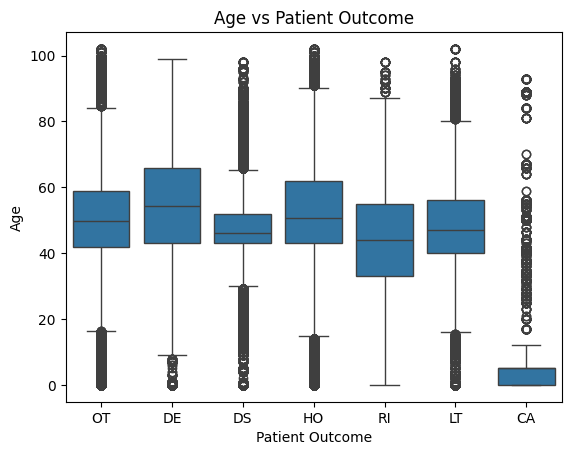

In [25]:
#d)年龄对健康结果的影响
import seaborn as sns
import pandas as pd
age_outcome_df = df6.select("AGE", "OUTC_COD").toPandas()
sns.boxplot(x="OUTC_COD", y="AGE", data=age_outcome_df)
plt.title("Age vs Patient Outcome")
plt.xlabel("Patient Outcome")
plt.ylabel("Age")
plt.show()

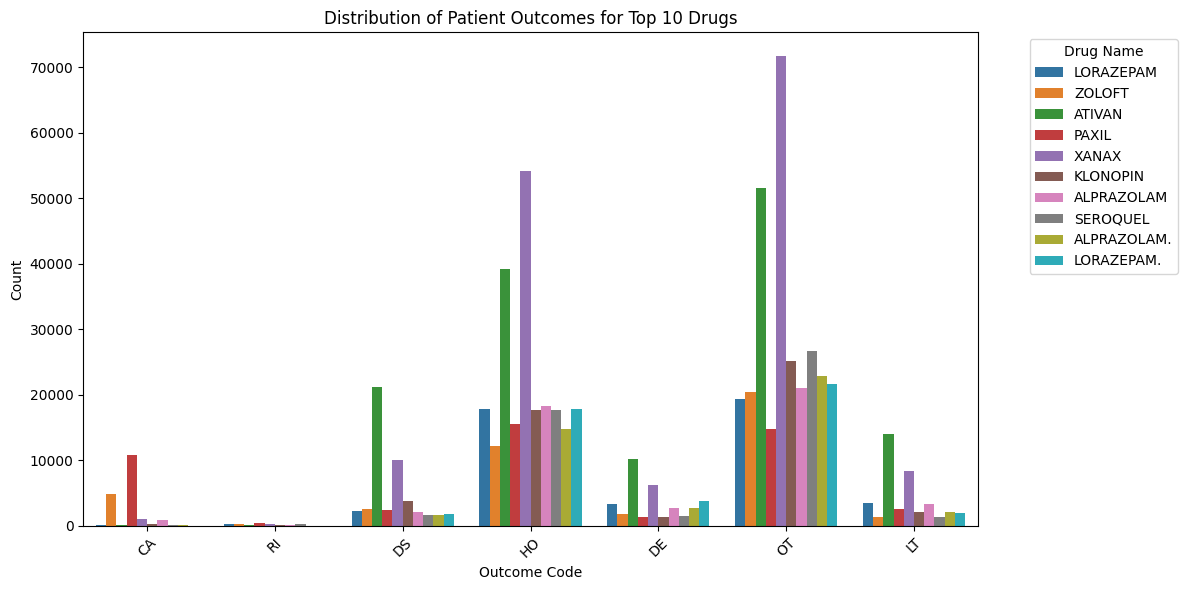

In [26]:
#e)Relationship between Drugname and outc-cod

drug_outcome = df6.groupBy("DRUGNAME", "OUTC_COD").count()
drug_outcome_pd = drug_outcome.toPandas()

# 最高频药物
top_drugs = (
    drug_outcome_pd.groupby("DRUGNAME")
    .sum()["count"]
    .nlargest(10)  # 选出前10名药物
    .index
)

filtered_data = drug_outcome_pd[drug_outcome_pd["DRUGNAME"].isin(top_drugs)]

plt.figure(figsize=(12, 6))
sns.barplot(data=filtered_data, x="OUTC_COD", y="count", hue="DRUGNAME")
plt.title("Distribution of Patient Outcomes for Top 10 Drugs")
plt.xlabel("Outcome Code")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Drug Name", bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout() 
plt.show()

In [27]:
#Chi-Square Test
from pyspark.sql.functions import col
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml.feature import StringIndexer, VectorAssembler
indexer_drug = StringIndexer(inputCol="DRUGNAME", outputCol="DRUGNAME_index").fit(df6)
df6 = indexer_drug.transform(df6)
indexer_outcome = StringIndexer(inputCol="OUTC_COD", outputCol="OUTC_COD_index").fit(df6)
df6 = indexer_outcome.transform(df6)
assembler_drug = VectorAssembler(inputCols=["DRUGNAME_index"], outputCol="features")
df_drug_outc = assembler_drug.transform(df6)
chi_square_test = ChiSquareTest.test(df_drug_outc, "features", "OUTC_COD_index")
chi_square_result = chi_square_test.head()
print(f"P-value: {chi_square_result.pValues[0]}, Degrees of Freedom: {chi_square_result.degreesOfFreedom[0]}")
#如果 P 值小于显著性水平0.05，可以认为 DRUGNAME 对 OUTC_COD 有显著影响,没跑出来重跑试试

P-value: 0.0, Degrees of Freedom: 32820


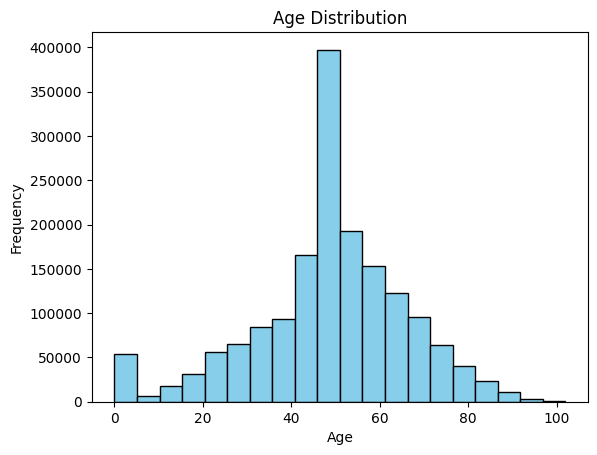

In [28]:
#f)年龄分布直方图
import matplotlib.pyplot as plt
ages = df6.select("AGE").rdd.flatMap(lambda x: x).collect()
plt.hist(ages, bins=20, color="skyblue", edgecolor="black")
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

+--------+------+
|OUTC_COD| count|
+--------+------+
|      LT| 92921|
|      RI|  8128|
|      CA| 32031|
|      HO|555679|
|      DE| 74648|
|      DS|119586|
|      OT|795453|
+--------+------+

None


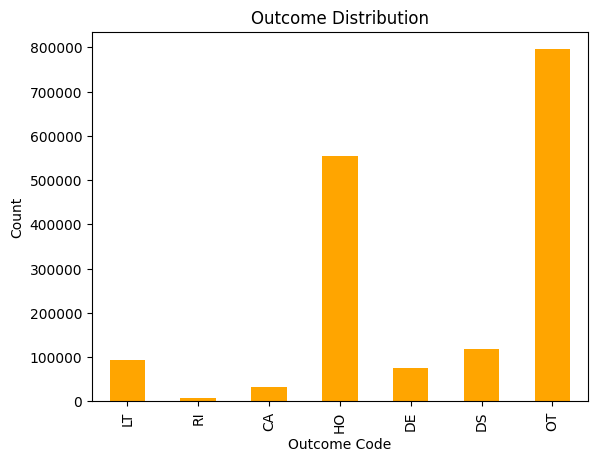

In [29]:
#g)各outcome发生频率
print(df6.groupBy("OUTC_COD").count().show())
outcomes = df6.groupBy("OUTC_COD").count().toPandas()
outcomes.plot(kind="bar", x="OUTC_COD", y="count", color="orange", legend=False)
plt.title("Outcome Distribution")
plt.xlabel("Outcome Code")
plt.ylabel("Count")
plt.show()

4- Method & Results:
What methods did you use? Are you using any tools in the Hadoop ecosystem (pyspark)?

In [30]:
train_data,test_data=feature_vector.randomSplit([0.5,0.5], seed = 27)

In [31]:
#linear regression
from pyspark.ml.regression import LinearRegression
outc_lr = LinearRegression(featuresCol = 'features',labelCol = 'OUTC_COD_index')
trained_outc_lr_model = outc_lr.fit(train_data)
outc_lr_results=trained_outc_lr_model.evaluate(test_data)
print('Mean Squared Error :',outc_lr_results.meanSquaredError)
print('Rsquared Error :',outc_lr_results.r2)

Mean Squared Error : 0.1368896179235511
Rsquared Error : 0.004930570828763026


In [33]:
#linear Regression出来的结果不是0/1/2，是float，进行四舍五入后计算一波test error
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
outc_lr_prediction = trained_outc_lr_model.transform(test_data)
outc_lr_prediction = outc_lr_prediction.withColumn("prediction", round("prediction", 0))
outc_lr_prediction.select("prediction", "OUTC_COD_index", "features").show(10)
evaluator = MulticlassClassificationEvaluator(labelCol="OUTC_COD_index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(outc_lr_prediction)
print("Test Accuracy = %g" % accuracy)
print("Test Error = %g " % (1.0 - accuracy))

+----------+--------------+--------------------+
|prediction|OUTC_COD_index|            features|
+----------+--------------+--------------------+
|       0.0|           0.0|[47.8246575342465...|
|       0.0|           0.0|[47.8246575342465...|
|       0.0|           0.0|[47.8246575342465...|
|       0.0|           0.0|[47.8246575342465...|
|       0.0|           0.0|[47.8246575342465...|
|       0.0|           0.0|[47.8246575342465...|
|       0.0|           0.0|[50.0,54.0,2020.0...|
|       0.0|           0.0|[50.0,54.0,2020.0...|
|       0.0|           0.0|[50.0,54.0,2020.0...|
|       0.0|           0.0|[50.0,54.0,2020.0...|
+----------+--------------+--------------------+
only showing top 10 rows

Test Accuracy = 0.863421
Test Error = 0.136579 


In [34]:
#multi - logistic regression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
outc_glr = LogisticRegression(labelCol="OUTC_COD_index", featuresCol="features", family="multinomial")
trained_outc_glr_Model = outc_glr.fit(train_data)
outc_glr_prediction = trained_outc_glr_Model.transform(test_data)
outc_glr_prediction.select("prediction", "OUTC_COD_index", "features").show(10)
evaluator = MulticlassClassificationEvaluator(labelCol="OUTC_COD_index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(outc_glr_prediction)
print("Test Accuracy = %g" % accuracy)
print("Test Error = %g " % (1.0 - accuracy))

+----------+--------------+--------------------+
|prediction|OUTC_COD_index|            features|
+----------+--------------+--------------------+
|       0.0|           0.0|[47.8246575342465...|
|       0.0|           0.0|[47.8246575342465...|
|       0.0|           0.0|[47.8246575342465...|
|       0.0|           0.0|[47.8246575342465...|
|       0.0|           0.0|[47.8246575342465...|
|       0.0|           0.0|[47.8246575342465...|
|       0.0|           0.0|[50.0,54.0,2020.0...|
|       0.0|           0.0|[50.0,54.0,2020.0...|
|       0.0|           0.0|[50.0,54.0,2020.0...|
|       0.0|           0.0|[50.0,54.0,2020.0...|
+----------+--------------+--------------------+
only showing top 10 rows

Test Accuracy = 0.863421
Test Error = 0.136579 


In [35]:
# Naive Bates
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(labelCol="OUTC_COD_index", featuresCol="features")
nbModel = nb.fit(train_data)
nb_prediction = nbModel.transform(test_data)
nb_prediction.select("prediction", "OUTC_COD_index", "features").show(10)
evaluator = MulticlassClassificationEvaluator(labelCol="OUTC_COD_index", predictionCol="prediction", metricName="accuracy" )
accuracy = evaluator.evaluate(nb_prediction)
print("Test Accuracy = %g" % accuracy)
print("Test Error = %g " % (1.0 - accuracy))

+----------+--------------+--------------------+
|prediction|OUTC_COD_index|            features|
+----------+--------------+--------------------+
|       1.0|           0.0|[47.8246575342465...|
|       1.0|           0.0|[47.8246575342465...|
|       1.0|           0.0|[47.8246575342465...|
|       1.0|           0.0|[47.8246575342465...|
|       0.0|           0.0|[47.8246575342465...|
|       0.0|           0.0|[47.8246575342465...|
|       2.0|           0.0|[50.0,54.0,2020.0...|
|       2.0|           0.0|[50.0,54.0,2020.0...|
|       2.0|           0.0|[50.0,54.0,2020.0...|
|       2.0|           0.0|[50.0,54.0,2020.0...|
+----------+--------------+--------------------+
only showing top 10 rows

Test Accuracy = 0.302568
Test Error = 0.697432 
